In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


Dataset and Preprocesing

In [124]:
# Load the dataset
df = pd.read_csv('defunciones_2021.csv')
df.head()

,anio_clave_geo,clave_geo_loc,clave_geo_mun,ent_regis,mun_regis,ent_resid,mun_resid,grado_marginacion,loc_resid,tloc_resid,...,rel_emba,rel_emba_d,razon_m,maternas,lista_mex_dgis,lista mex_inegi,grupo_cancer,desc_basica,anio_regis,ent_resid_desc
0,202114039,140390001,14039,14,39,14,39,Muy bajo,1,16,...,8,No aplica,0,NaN,COVID-19,COVID-19,NaN,"COVID-19, virus identificado",2021,Jalisco
1,202114039,140390001,14039,14,98,14,39,Muy bajo,1,16,...,8,No aplica,0,NaN,Enfermedades del hígado,Otras enfermedades del hígado,NaN,"INSUFICIENCIA HEPÁTICA, NO ESPECIFICADA",2021,Jalisco
2,202114039,140390001,14039,14,78,14,39,Muy bajo,1,16,...,8,No aplica,0,NaN,Otras Causas,"Las demás enfermedades de la sangre, órganos h...",NaN,TROMBOCITOPENIA NO ESPECIFICADA,2021,Jalisco
3,202114103,141030015,14103,14,98,14,103,Muy bajo,15,4,...,8,No aplica,0,NaN,Accidentes,Accidentes de tráfico de vehículos de motor,NaN,MOTOCICLISTA LESIONADO EN ACCIDENTE DE TRANSPO...,2021,Jalisco
4,202114092,140920001,14092,14,91,14,92,Bajo,1,4,...,8,No aplica,0,NaN,Otras Causas,Las demás enfermedades del aparato respiratorio,NaN,OTROS TRASTORNOS DEL PULMÓN,2021,Jalisco


In [105]:
# Basic exploration
print("Shape of the dataset:", df.shape)
df.info()
print(df.describe())

# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

df.dtypes


Shape of the dataset: (74568, 56)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74568 entries, 0 to 74567
Data columns (total 56 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   anio_clave_geo     74568 non-null  int64 
 1   clave_geo_loc      74568 non-null  int64 
 2   clave_geo_mun      74568 non-null  int64 
 3   ent_regis          74568 non-null  int64 
 4   mun_regis          74568 non-null  int64 
 5   ent_resid          74568 non-null  int64 
 6   mun_resid          74568 non-null  int64 
 7   grado_marginacion  74546 non-null  object
 8   loc_resid          74568 non-null  int64 
 9   tloc_resid         74568 non-null  int64 
 10  tam_loc_resid      74568 non-null  object
 11  ent_ocurr          74568 non-null  int64 
 12  mun_ocurr          74568 non-null  int64 
 13  loc_ocurr          74568 non-null  int64 
 14  tloc_ocurr         74568 non-null  int64 
 15  tam_loc_ocurr      74568 non-null  object
 16  causa_

2 Preprocesing

In [ ]:
# 2.1 Data Encoding

# Map datatypes
df['grado_marginacion'] = df['grado_marginacion'].map({'Muy bajo': 1, 'Bajo': 2, 'Medio': 3, 'Alto': 4, 'Muy alto': 5})
df['tipo_edad'] = df['tipo_edad'].map({'Años': 1, 'Meses': 2, 'Días': 3, 'Horas': 4, 'Minutos': 5})
# Create a binary feature for diagnoses containing "renal" or "renales"
df_balanced['contains_renal'] = df_balanced['desc_basica'].str.contains('renal|renales', case=False, na=False).astype(int)

# 2.2 Data Imputation

#KNN and mode imputation
# Handle Missing Values
df['lista mex_inegi'] = df['lista mex_inegi'].fillna('None')
df['desc_basica'] = df['desc_basica'].fillna('None')
mean_value = df['grado_marginacion'].mean()
df['grado_marginacion'] = df['grado_marginacion'].fillna(mean_value)

# 2.3 Data Scaling

#Normalization
# Normalize the text in 'desc_basica'
df['desc_basica'] = df['desc_basica'].str.lower().str.strip()


Feature Selection

In [ ]:
# Drop columns
df.drop(columns=[
    'ent_regis', 'ent_resid', 'tam_loc_resid', 'ent_ocurr', 'tloc_ocurr',
    'tam_loc_ocurr', 'sexo_d', 'edad', 'grupo_edad', 'dia_ocurr',
    'dia_nacim', 'mes_nacim', 'anio_nacim', 'escolaridad_d', 'edo_civil_d',
    'ocurr_trab', 'ocurr_trab_d', 'lugar_ocur', 'lugar_ocur_d', 'cond_cert',
    'cond_cert_d', 'derechohab_d', 'embarazo', 'embarazoD', 'rel_emba',
    'rel_emba_d', 'razon_m', 'maternas', 'lista_mex_dgis', 'grupo_cancer',
    'ent_resid_desc'
], inplace=True)

Diagnosis with renal

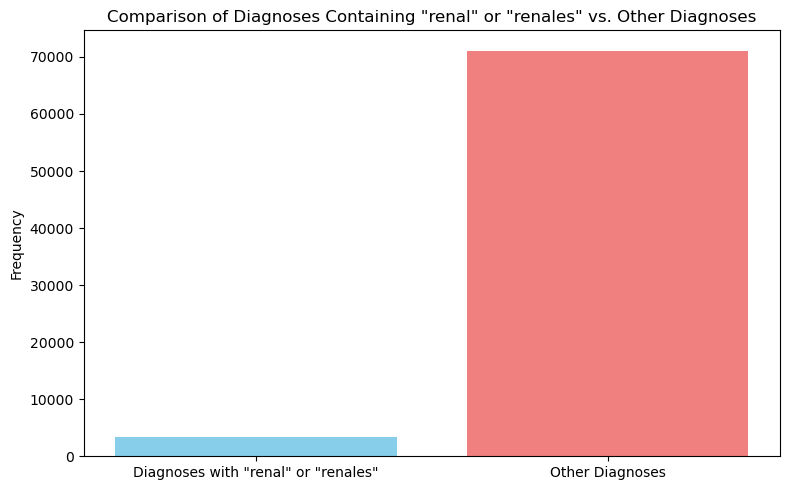

Number of diagnoses containing 'renal' or 'renales': 3461
Number of other diagnoses: 71107


In [ ]:
# Filter diagnoses that contain "renal" or "renales"
renal_diagnoses = df[df['desc_basica'].str.contains('renal|renales', case=False, na=False)]
non_renal_diagnoses = df[~df['desc_basica'].str.contains('renal|renales', case=False, na=False)]

# Count the frequency of each group
renal_count = len(renal_diagnoses)
non_renal_count = len(non_renal_diagnoses)

# Prepare data for plotting
labels = ['Diagnoses with "renal" or "renales"', 'Other Diagnoses']
counts = [renal_count, non_renal_count]

# Plot the comparison
plt.figure(figsize=(8, 5))
plt.bar(labels, counts, color=['skyblue', 'lightcoral'])
plt.title('Comparison of Diagnoses Containing "renal" or "renales" vs. Other Diagnoses')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # No rotation for x labels
plt.tight_layout()  # Adjust layout
plt.show()

# Display the counts
print(f"Number of diagnoses containing 'renal' or 'renales': {renal_count}")
print(f"Number of other diagnoses: {non_renal_count}")


3.4. Model Training

In [ ]:
# Hyperparameter optimization (HPO)


# XAI Integration Module

3.5. Performance Metrics

In [ ]:
# recall, accuracy, precision, and F1 score, AUC, ROC

Validation